In [96]:
import requests
import spacy
import json
from openai import OpenAI
import exif 
import base64
from base64 import b64encode, b64decode
import tqdm

In [33]:
nlp = spacy.load("en_core_web_sm")

API_KEY = open('apikey').read()

baltimore_harbor = {
    "circle": {
        "center": {
            "latitude": 39.2820552,
            "longitude": -76.6051076
        },
        "radius": 500
    }
}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.4.0) was trained with spaCy v3.4.0 and may not be 100% compatible with the current version (3.7.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [34]:
def nearby_places(locationRestriction, url="https://places.googleapis.com/v1/places:searchNearby"):
    body = {
        "maxResultCount": 10,
        "rankPreference": "DISTANCE",
        "locationRestriction": locationRestriction
    }

    headers = {
        "X-Goog-Api-Key": API_KEY,
        "X-Goog-FieldMask": "places.displayName,places.photos"
    }
    
    r = requests.post(url, headers=headers, json=body)
    return r.json()

In [135]:
places = nearby_places(baltimore_harbor)
# places = json.load(open("places"))
places

{'places': [{'displayName': {'text': 'National Aquarium',
    'languageCode': 'en'},
   'photos': [{'name': 'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuEP3MVI1hiU6ajvNlXwHw5Aonhlh497f-uvO7mJW_Iy0YmBQISIHADC9ZYzVNnvcWfv9bXCyINiPVSK9XVI_6xKUuQ9lwJZo8aLjp_cMVukQ0moGZtJqFB6NoITI0wsgGqUI1CVMtNQbXKjvQxpjRcTIxawxfQysEhp',
     'widthPx': 4032,
     'heightPx': 3024,
     'authorAttributions': [{'displayName': 'Cody Anderson',
       'uri': '//maps.google.com/maps/contrib/102004674886082438883',
       'photoUri': '//lh3.googleusercontent.com/a/ACg8ocIwwnkYyw-BFqGIdnwExhhT-by6Ptddb2dtFxR68QDS=s100-p-k-no-mo'}]},
    {'name': 'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuFj63VhPEQQUWjmWPEKWT4kVw9Cg539ON_Z8ZAh13-ijhMJ58fzxRRkIlqb1fkNbsuc9My2985Zej_El7vyKkcP0va3MI5NVko7RxGe1goE4c961wS6WOEmyJivXrOeITYfJKUdjvsuYi3xer-tcnGcl7GZFccYJc0F',
     'widthPx': 4032,
     'heightPx': 3024,
     'authorAttributions': [{'displayName': 'Chloe Trippe',
       'uri': '//maps.google.com/maps/contrib/11621

In [6]:
reviews = {p['displayName']['text']: [i['text']['text'] for i in p['reviews']] for p in places['places']}

In [9]:
from collections import Counter

reviews_counter = {}
for n, rs in reviews.items():
    adjs = [token.lemma_ for r in rs for token in nlp(r) if token.pos_ == "ADJ"]
    reviews_counter[n] = Counter(adjs)
reviews_counter

{'National Aquarium': Counter({'other': 3,
          'big': 3,
          'cool': 3,
          'great': 3,
          'hard': 2,
          'super': 2,
          'clean': 2,
          'worth': 2,
          'beautiful': 2,
          'busy': 2,
          'fantastic': 2,
          'more': 2,
          'happy': 2,
          'few': 2,
          'good': 2,
          'vertical': 2,
          'impressive': 1,
          'surprised': 1,
          'modern': 1,
          'easy': 1,
          'many': 1,
          'amazing': 1,
          'entire': 1,
          'little': 1,
          'confusing': 1,
          'wide': 1,
          'tropical': 1,
          'worthy': 1,
          'friendly': 1,
          'underwater': 1,
          'huge': 1,
          'fun': 1,
          'awesome': 1,
          'sure': 1,
          'jellyfish': 1,
          'hidden': 1,
          'favorite': 1,
          'unimpressed': 1,
          'most': 1,
          'small': 1,
          'various': 1,
          'geographical': 1,
      

In [136]:
# place photos: https://developers.google.com/maps/documentation/places/web-service/place-photos
photos = {p['displayName']['text']: [i['name'] for i in p['photos']] for p in places['places']}
photos

{'National Aquarium': ['places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuEP3MVI1hiU6ajvNlXwHw5Aonhlh497f-uvO7mJW_Iy0YmBQISIHADC9ZYzVNnvcWfv9bXCyINiPVSK9XVI_6xKUuQ9lwJZo8aLjp_cMVukQ0moGZtJqFB6NoITI0wsgGqUI1CVMtNQbXKjvQxpjRcTIxawxfQysEhp',
  'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuFj63VhPEQQUWjmWPEKWT4kVw9Cg539ON_Z8ZAh13-ijhMJ58fzxRRkIlqb1fkNbsuc9My2985Zej_El7vyKkcP0va3MI5NVko7RxGe1goE4c961wS6WOEmyJivXrOeITYfJKUdjvsuYi3xer-tcnGcl7GZFccYJc0F',
  'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuFCGhgo19B-j7V1wJAcIac77tBITPLXDufHyU21XWd97rb6NNphpO75qutLbsEd38rmS565NI9QdySpn9o2t4jCA1OOM9VmNZMVwlq8BQRN2bNPdr2cHNrD1VwJVlhiZRiqBZsrEaLAXDNwDrym-oYm9WKnZ3NozPp1',
  'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuEOYb5twaj3bCRB0LRB0JcSO_vxe33e0MthIDEGzWYJQcXloSuyU7LcQO1s963CsfvtJZU7a51Kyxc39BCbv-loAkRogWdq6iwgt0gNYc3Lf9KGRrWfvhdNojqZY1Rk5rAHfxpEG2bqFD88JvKE9xUg5yeRTpYRqJUe',
  'places/ChIJXVZn5GIDyIkRjn58fGGo8Mc/photos/AcJnMuEckYXGdJlGeocRCR594fccZvEYsj9MqtxxuM1L35zrV7CHKj4mCRdLEc97nEEE-K

In [140]:
# https://openai.com/pricing
# pricing is determined by number of 512x512 blocks in an image
def get_photo(name, size=512, url="https://places.googleapis.com/v1/{name}/media?key={key}&maxHeightPx={size}&maxWidthPx={size}"):
    r = requests.get(url.format(name=name, key=API_KEY, size=size), stream=True)
    return r.content

def get_exif(name):
    return exif.Image(get_photo(name))


In [111]:
e = exif.Image(open("testt.jpeg", "rb"))
e.software

'Google'

In [133]:
# real_photos = {i: [get_exif(j) for j in k] for i, k in photos.items()}
real_photos = {}
for i, k in photos.items():
#     for j in k
#     real_photos[i] = [get_photo(j) for j in tqdm.tqdm(k)]
#     print(real)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.21it/s]

 10%|██████████████▉                                                                                                                                      | 1/10 [00:00<00:02,  4.34it/s]

KeyboardInterrupt: 

In [134]:
real_photos

{'National Aquarium': [b'{\n  "error": {\n    "code": 400,\n    "message": "The photo resource in the request is invalid. Please retrieve it from Places API endpoints.",\n    "status": "INVALID_ARGUMENT"\n  }\n}\n',
  b'{\n  "error": {\n    "code": 400,\n    "message": "The photo resource in the request is invalid. Please retrieve it from Places API endpoints.",\n    "status": "INVALID_ARGUMENT"\n  }\n}\n',
  b'{\n  "error": {\n    "code": 400,\n    "message": "The photo resource in the request is invalid. Please retrieve it from Places API endpoints.",\n    "status": "INVALID_ARGUMENT"\n  }\n}\n',
  b'{\n  "error": {\n    "code": 400,\n    "message": "The photo resource in the request is invalid. Please retrieve it from Places API endpoints.",\n    "status": "INVALID_ARGUMENT"\n  }\n}\n',
  b'{\n  "error": {\n    "code": 400,\n    "message": "The photo resource in the request is invalid. Please retrieve it from Places API endpoints.",\n    "status": "INVALID_ARGUMENT"\n  }\n}\n',
  b'

In [158]:
# import shutil
# p = get_photo('places/ChIJ20bAk1D2t4kRScYfblDwzI0/photos/AcJnMuFBCoGeGigltVI_6r8MMj_TbqkHTGJsunAd6RYeZ1lFpWinlJu13WIMikgvlouoJU610z6vPyZU8CozwDuK-6VkWmYFO9Ip9Bks8ATZ5umLpANv--rdMuaWDltLobPAC4RRGOy4yW7mFNGMPFnealinrjGnN8XtqktI')
# with open('img.jpg', 'wb') as out_file:
#     shutil.copyfileobj(p, out_file)

p = get_photo('places/ChIJJSgkzWQDyIkRt-l143HvRh4/photos/AcJnMuGNTTxPf-uitIbOsV1FlYbzqfbxQbz3R6E0LHBEXRraLWc75AZgXfkEKJbjnWIEadVNE2sC9Octw7j92rUoa8m3VP31JnzhveQaSesiPstdM6HylB4tby9jX0evyfJhjL8OmDkETs12dNgVMdbJZSmiN-VJymv0EYCq')
open("ijtoer.jpg", "wb").write(p)

106160

In [81]:
import exif

In [152]:
e = exif.Image(p)
e.software

'Google'

In [159]:
from base64 import b64encode
# b = b64encode(open('img.jpg', 'rb').read())
b = b64encode(p)


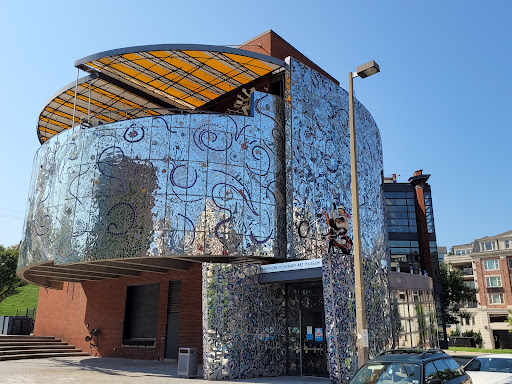

In [160]:
from IPython import display
from base64 import b64decode
from io import BytesIO 
from PIL import Image


display.Image(b64decode(b))

In [144]:
from openai import OpenAI

In [145]:
openapikey = open("openapikey").read()

In [146]:
client = OpenAI(api_key=openapikey)

In [161]:
import base64
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


base64_image = b.decode('utf-8')

In [163]:
# "For the images in this set that describe a building, "

prompt = (
    "Use exactly ten adjectives and no more words to describe the common building in these images. "
    "Describe the size, shape, color, style, feel, texture, material, appearance, design, and architecture. "
    "Label each adjective by what it describes."
)


response = client.chat.completions.create(
  model="gpt-4-vision-preview",
  messages=[
    {
      "role": "user",
      "content": [
        {"type": "text", "text": prompt},
        {
          "type": "image_url",
          "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}",
              "detail": "low"
          },
        },
      ],
    }
  ],
  max_tokens=300,
)

print(response.choices[0])

Choice(finish_reason=None, index=0, message=ChatCompletionMessage(content='Size: Large\nShape: Curvilinear\nColor: Multicolored\nStyle: Modern\nFeel: Welcoming\nTexture: Textured\nMaterial: Metallic\nAppearance: Artistic\nDesign: Unique\nArchitecture: Innovative', role='assistant', function_call=None, tool_calls=None), finish_details={'type': 'stop', 'stop': '<|fim_suffix|>'})


In [ ]:
""